In [18]:
import json

with open('burgers_results_n_[64]_avg.json') as file:
    data = json.load(file)


best_relu_setups = {}

for experiment, details in data.items():
    if all(details['training_info']['is_converged_values']):  # Check if all runs converged
        n_modes = details['branch_config']['dense_layer']['layer_width']
        activation = details['branch_config']['dense_layer']['activation']

        # Calculate the minimum loss
        iteration_losses = [value for key, value in details['training_info'].items() 
                            if key.startswith('iteration_') and key.endswith('_loss')]
        min_loss = min(iteration_losses) if iteration_losses else float('inf')

        # Update best setup for ReLU activation
        if activation == 'relu':
            if n_modes not in best_relu_setups or min_loss < best_relu_setups[n_modes]['best_loss']:
                best_relu_setups[n_modes] = {
                    'best_loss': min_loss,
                    'parameters': details['branch_config']
                }

# Display the best parameter setups for ReLU for each layer width
for width, setup in best_relu_setups.items():
    print(f"Layer Width: {width}")
    print(f"Best Loss: {setup['best_loss']}")
    print("Parameters:")
    for key, value in setup['parameters'].items():
        print(f"  {key}: {value}")
    print("\n")


Layer Width: 256
Best Loss: 5.3064559305408044e-05
Parameters:
  dense_layer: {'layer_width': 256, 'activation': 'relu', 'parameter_sampler': 'relu'}
  linear_layer: {'regularization_scale': 1e-08}


Layer Width: 512
Best Loss: 2.7611253278545225e-05
Parameters:
  dense_layer: {'layer_width': 512, 'activation': 'relu', 'parameter_sampler': 'relu'}
  linear_layer: {'regularization_scale': 1e-06}


Layer Width: 1024
Best Loss: 1.6304787251558636e-05
Parameters:
  dense_layer: {'layer_width': 1024, 'activation': 'relu', 'parameter_sampler': 'relu'}
  linear_layer: {'regularization_scale': 0.0001}


Layer Width: 2048
Best Loss: 5.869788262985857e-06
Parameters:
  dense_layer: {'layer_width': 2048, 'activation': 'relu', 'parameter_sampler': 'relu'}
  linear_layer: {'regularization_scale': 1e-08}




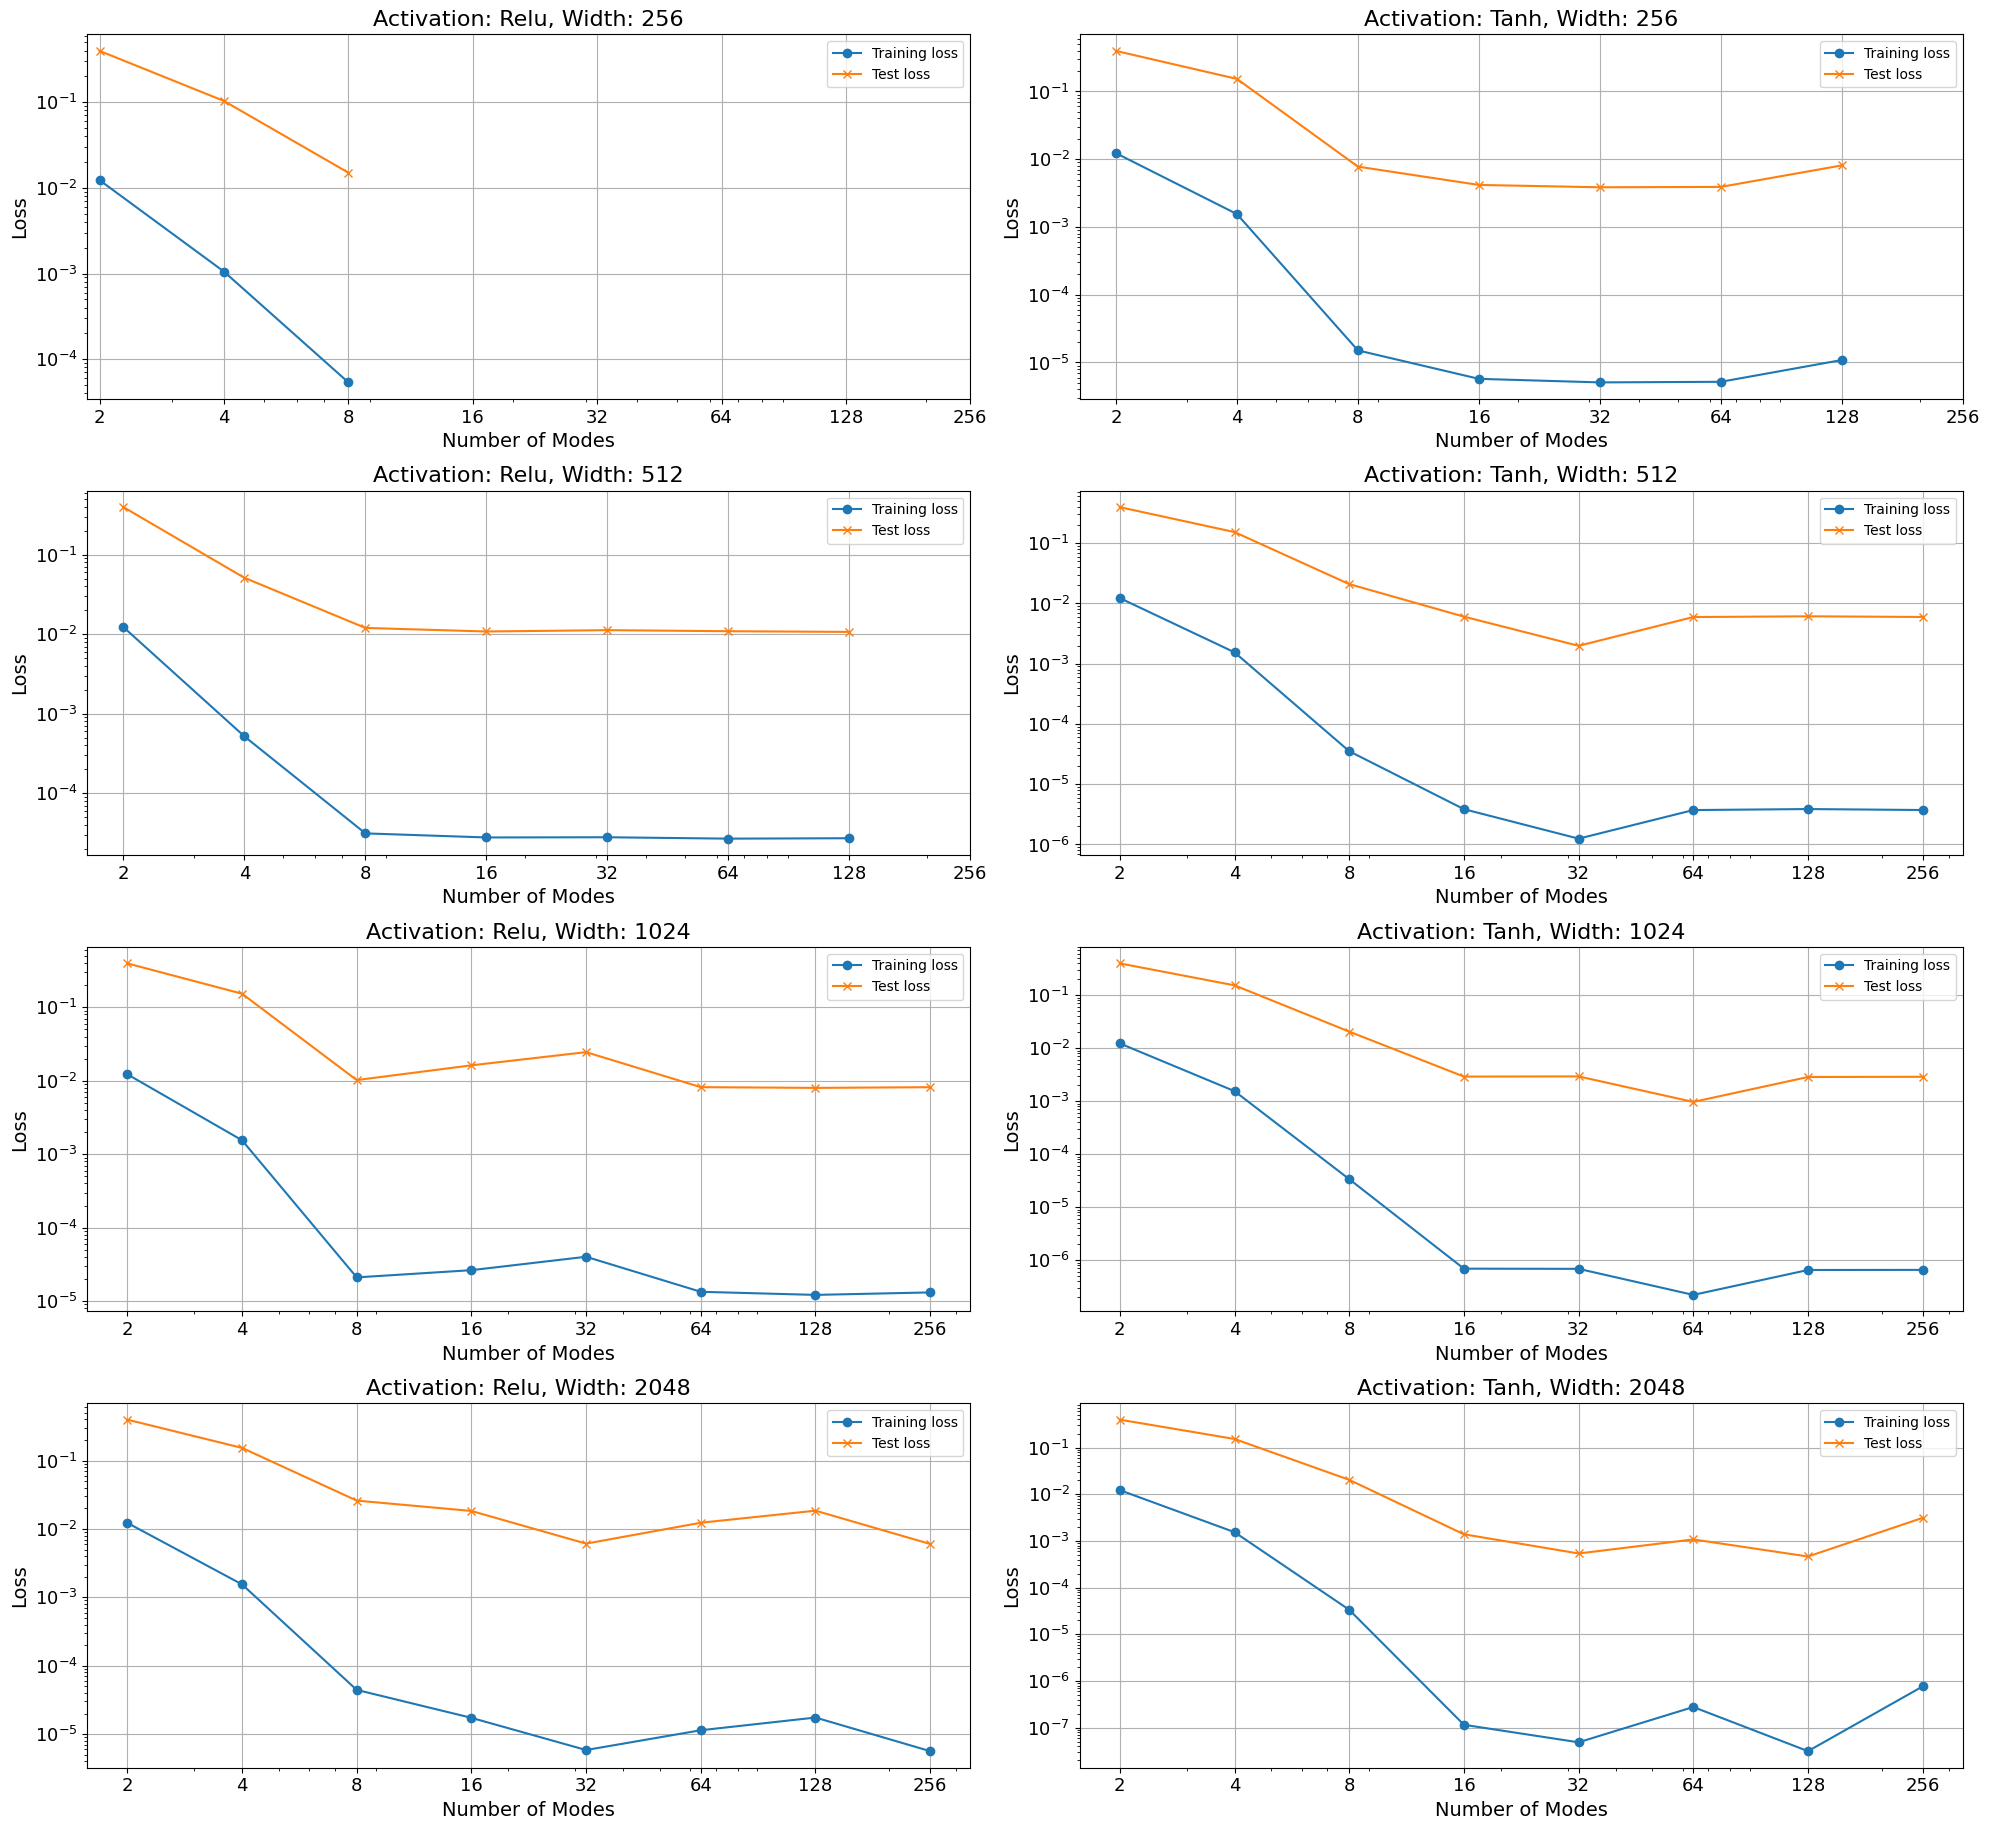

In [19]:
import json
import matplotlib.pyplot as plt
import numpy as np


file_names = [
    "burgers_results_n_[2]_avg.json",
    "burgers_results_n_[4]_avg.json",
    "burgers_results_n_[8]_avg.json",
    "burgers_results_n_[16]_avg.json",
    "burgers_results_n_[32]_avg.json",
    "burgers_results_n_[64]_avg.json",
    "burgers_results_n_[128]_avg.json",
    "burgers_results_n_[256]_avg.json"
]

n_rows = 4 
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))

configs = ['relu-256', 'relu-512', 'relu-1024', 'relu-2048', 'tanh-256', 'tanh-512', 'tanh-1024', 'tanh-2048']
train_losses = {config: {mode: float('inf') for mode in [2, 4, 8, 16, 32, 64, 128, 256]} for config in configs}
test_losses = {config: {mode: float('inf') for mode in [2, 4, 8, 16, 32, 64, 128, 256]} for config in configs}

for file_name in file_names:
    n_modes = int(file_name.split('_')[3].strip('[]'))
    with open(file_name) as file:
        data = json.load(file)

    for experiment, details in data.items():
        if all(details['training_info']['is_converged_values']):
            layer_width = details['branch_config']['dense_layer']['layer_width']
            activation = details['branch_config']['dense_layer']['activation']
            
            # Find the best training loss configuration
            min_loss = float('inf')
            min_iteration = None
            for key, value in details['training_info'].items():
                if key.startswith('iteration_') and key.endswith('_loss') and value > 0 and value < min_loss:
                    min_loss = value
                    min_iteration = int(key.split('_')[1])
            
            config_name = f"{activation}-{layer_width}"
            if config_name in configs:
                train_losses[config_name][n_modes] = min_loss
                
                if min_iteration is not None:
                    # Extract corresponding test loss
                    test_loss_key = f"iteration_{min_iteration}_test_loss"
                    test_loss = details['test_info'].get(test_loss_key, float('inf'))
                    test_losses[config_name][n_modes] = test_loss

# Plotting
mode_values = [2, 4, 8, 16, 32, 64, 128, 256]
relu_configs = ['relu-256', 'relu-512', 'relu-1024', 'relu-2048']
tanh_configs = ['tanh-256', 'tanh-512', 'tanh-1024', 'tanh-2048']

for i, config in enumerate(relu_configs + tanh_configs):
    column_index = 0 if config in relu_configs else 1

    ax = axes[i % n_rows, column_index]
    sorted_train_losses = [train_losses[config][mode] for mode in mode_values if train_losses[config][mode] < float('inf')]
    sorted_test_losses = [test_losses[config][mode] for mode in mode_values if test_losses[config][mode] < float('inf')]
    
    ax.plot(mode_values[:len(sorted_train_losses)], sorted_train_losses, label=f'Training loss', marker='o')
    ax.plot(mode_values[:len(sorted_test_losses)], sorted_test_losses, label=f'Test loss', marker='x')

    ax.set_xscale('log')
    ax.set_xticks(mode_values)
    ax.set_xticklabels([str(m) for m in mode_values])
    ax.set_xlabel('Number of Modes', fontsize=14)
    ax.set_ylabel('Loss', fontsize=14)
    ax.set_yscale('log')

    activation, width = config.split('-')
    ax.set_title(f"Activation: {activation.capitalize()}, Width: {width}", fontsize=16)

    ax.tick_params(axis='both', labelsize=13)
    ax.grid(True)

for ax in axes.flat:
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


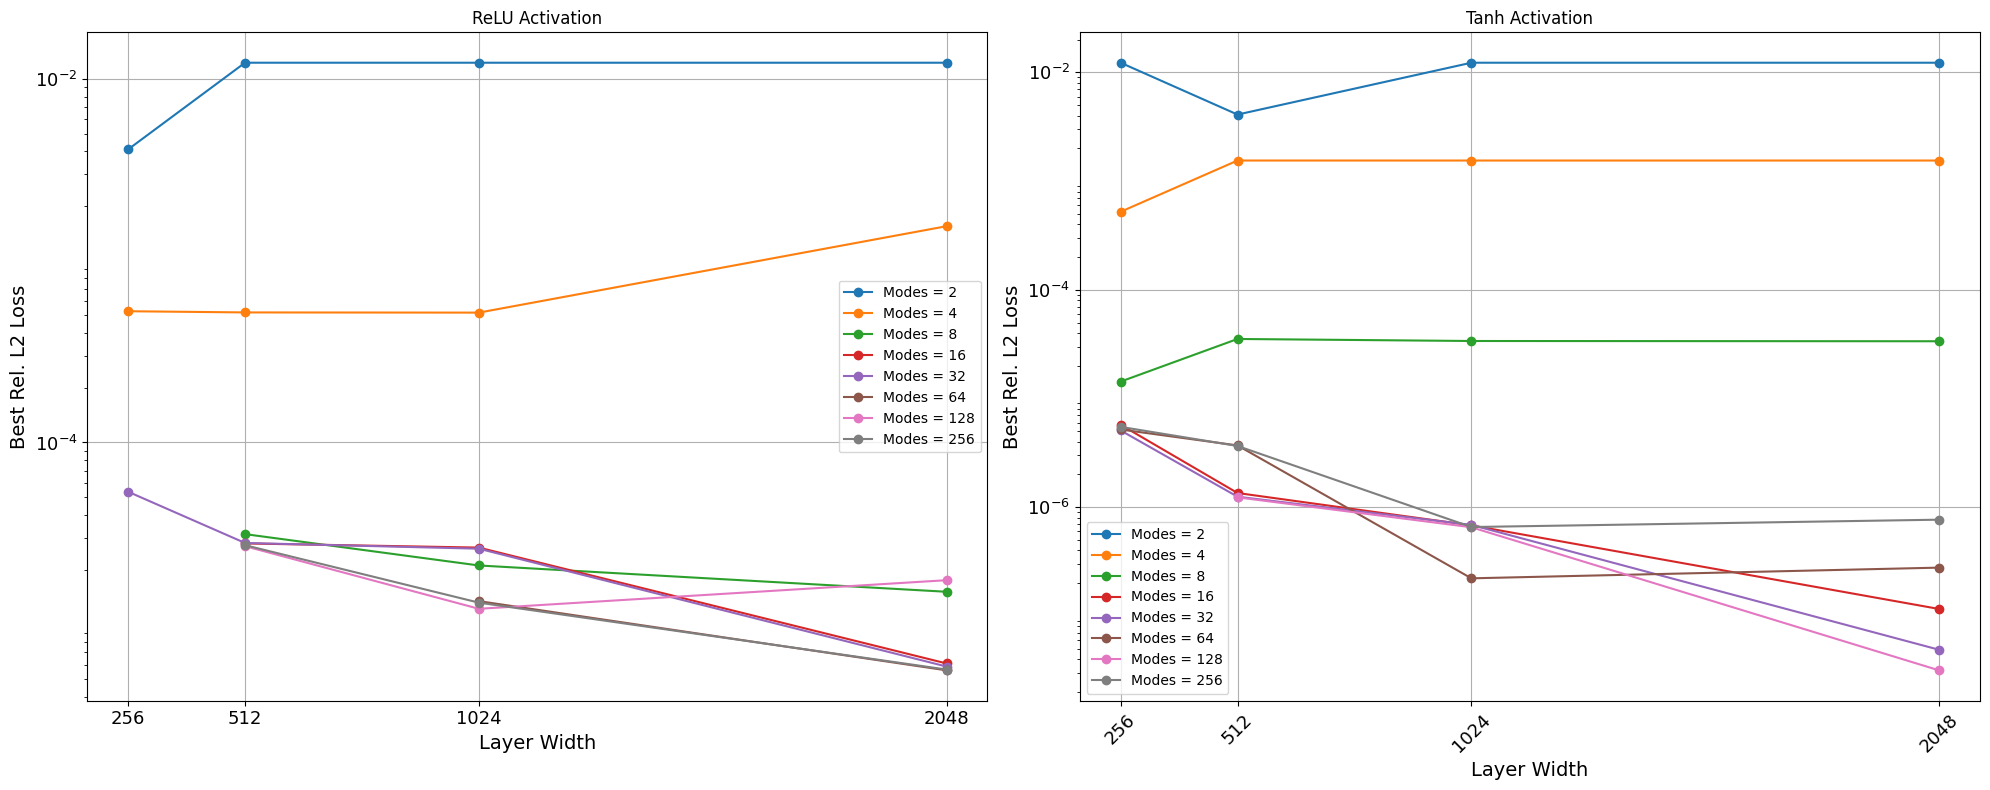

In [15]:
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.ticker import LogFormatter


file_names = [
    "burgers_results_n_[2]_avg.json",
    "burgers_results_n_[4]_avg.json",
    "burgers_results_n_[8]_avg.json",
    "burgers_results_n_[16]_avg.json",
    "burgers_results_n_[32]_avg.json",
    "burgers_results_n_[64]_avg.json",
    "burgers_results_n_[128]_avg.json",
    "burgers_results_n_[256]_avg.json"
]

def process_file(file_name, activation_function):
    best_losses = {}
    with open(file_name) as file:
        data = json.load(file)
    for experiment, details in data.items():
        if all(details['training_info']['is_converged_values']) and details['branch_config']['dense_layer']['activation'] == activation_function:
            layer_width = details['branch_config']['dense_layer']['layer_width']
            iteration_losses = [value for key, value in details['training_info'].items() if key.startswith('iteration_') and key.endswith('_loss')]
            min_loss = min(iteration_losses) if iteration_losses else float('inf')
            if layer_width not in best_losses or min_loss < best_losses[layer_width][0]:
                best_losses[layer_width] = (min_loss, experiment)
    return best_losses

class CustomLogFormatter(mticker.LogFormatter):
    def __call__(self, val, pos=None):
        if val == 0:  # Handle the zero case
            return '1'
        elif val == 1:
            return '10'
        else:
            exponent = int(np.log10(val))
            return r'$10^{{{}}}$'.format(exponent)

best_losses_per_mode_relu = {}
best_losses_per_mode_tanh = {}

for file_name in file_names:
    n_modes = int(file_name.split('_')[3].strip('[]'))
    best_losses_per_mode_relu[n_modes] = process_file(file_name, 'relu')
    best_losses_per_mode_tanh[n_modes] = process_file(file_name, 'tanh')

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
custom_log_formatter = CustomLogFormatter()
log_locator = mticker.LogLocator(numticks=3)

x_ticks = [256, 512, 1024, 2048]  # Define custom x-axis ticks

# Plot for ReLU
for n_modes, losses in best_losses_per_mode_relu.items():
    min_losses = [loss_info[0] for loss_info in losses.values() if loss_info[0] != float('inf')]
    x_values = [key for key in losses.keys() if losses[key][0] != float('inf')]
    axes[0].plot(x_values, min_losses, label=f'Modes = {n_modes}', marker='o')

axes[0].set_xticks(x_ticks)  # Set custom x-ticks
axes[0].set_xticklabels(x_ticks)  # Set x-tick labels
axes[0].set_yscale('log')  # Set y-axis to logarithmic scale
axes[0].yaxis.set_major_formatter(custom_log_formatter)
axes[0].yaxis.set_major_locator(log_locator)
axes[0].set_xlabel('Layer Width', fontsize=14)
axes[0].set_ylabel('Best Rel. L2 Loss', fontsize=14)
axes[0].set_title('ReLU Activation')
axes[0].tick_params(axis='both', labelsize=13)
axes[0].legend()
axes[0].grid(True)

# Plot for Tanh
for n_modes, losses in best_losses_per_mode_tanh.items():
    min_losses = [loss_info[0] for loss_info in losses.values() if loss_info[0] != float('inf')]
    x_values = [key for key in losses.keys() if losses[key][0] != float('inf')]
    axes[1].plot(x_values, min_losses, label=f'Modes = {n_modes}', marker='o')

axes[1].set_xticks(x_ticks)  # Set custom x-ticks
axes[1].set_xticklabels(x_ticks, rotation=45)  # Set x-tick labels with rotation
axes[1].set_yscale('log')  # Set y-axis to logarithmic scale
axes[1].yaxis.set_major_formatter(custom_log_formatter)
axes[1].yaxis.set_major_locator(log_locator)
axes[1].set_xlabel('Layer Width', fontsize=14)
axes[1].set_ylabel('Best Rel. L2 Loss', fontsize=14)
axes[1].set_title('Tanh Activation')
axes[1].tick_params(axis='both', labelsize=13)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [8]:
best_losses_per_mode_relu

{2: {256: (0.0040933417769604755, 'experiment_7'),
  512: (0.01227552234299331, 'experiment_15'),
  1024: (0.012273921165565506, 'experiment_24'),
  2048: (0.01227321216262648, 'experiment_32')},
 4: {256: (0.0005271134903571781, 'experiment_5'),
  512: (0.0005192190527221662, 'experiment_16'),
  1024: (0.0005179881477546446, 'experiment_21'),
  2048: (0.0015477592567311308, 'experiment_30')},
 8: {512: (3.131456344088091e-05, 'experiment_14'),
  1024: (2.105316206959199e-05, 'experiment_23'),
  2048: (1.5087641770908192e-05, 'experiment_30')},
 16: {512: (2.7832289793563374e-05, 'experiment_15'),
  1024: (2.640680843663955e-05, 'experiment_22'),
  2048: (6.085239756017866e-06, 'experiment_31')},
 32: {256: (5.357333387516988e-05, 'experiment_6'),
  512: (2.7999382527044034e-05, 'experiment_16'),
  1024: (2.6037922416653755e-05, 'experiment_23'),
  2048: (5.851510796695989e-06, 'experiment_31')},
 64: {1024: (1.340225694499818e-05, 'experiment_24'),
  2048: (5.576785292155741e-06, 'exp

In [9]:
best_losses_per_mode_tanh

{2: {256: (0.012273951709771613, 'experiment_4'),
  512: (0.004092152387565515, 'experiment_9'),
  1024: (0.012272741811916454, 'experiment_20'),
  2048: (0.012272728602012267, 'experiment_28')},
 4: {256: (0.0005219055885358142, 'experiment_1'),
  512: (0.0015459052306334275, 'experiment_12'),
  1024: (0.0015454642928103969, 'experiment_20'),
  2048: (0.0015454229792804977, 'experiment_28')},
 8: {256: (1.4296528345147758e-05, 'experiment_2'),
  512: (3.527766185664308e-05, 'experiment_12'),
  1024: (3.378990073027815e-05, 'experiment_20'),
  2048: (3.36071414557647e-05, 'experiment_28')},
 16: {256: (5.733516816710335e-06, 'experiment_4'),
  512: (1.350006534013711e-06, 'experiment_11'),
  1024: (6.804831090443315e-07, 'experiment_19'),
  2048: (1.157415730258697e-07, 'experiment_28')},
 32: {256: (5.080629330289041e-06, 'experiment_4'),
  512: (1.2484087664965568e-06, 'experiment_12'),
  1024: (6.869292593929784e-07, 'experiment_20'),
  2048: (4.879115644799222e-08, 'experiment_27')

In [10]:
# Find the minimum loss and corresponding experiment
min_loss_info = min(
    (loss_info for losses in best_losses_per_mode_tanh.values() for loss_info in losses.values()),
    key=lambda x: x[0]
)

# Extract the minimum loss and corresponding experiment number
min_loss, corresponding_experiment = min_loss_info

# Now you can print or use min_loss and corresponding_experiment as needed
print(f"The minimum loss is {min_loss} which is achieved in {corresponding_experiment}.")

The minimum loss is 3.153564423343568e-08 which is achieved in experiment_28.


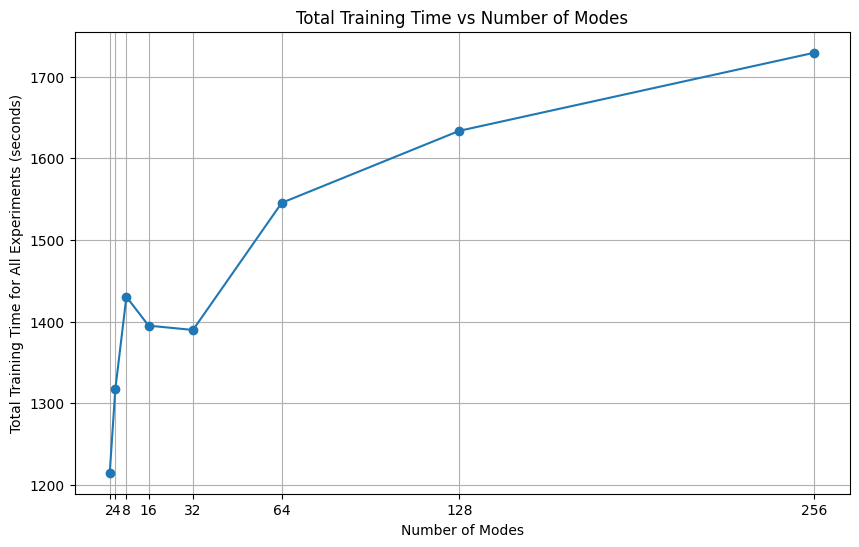

In [11]:
import json
import matplotlib.pyplot as plt

file_names = [
    "burgers_results_n_[2]_avg.json",
    "burgers_results_n_[4]_avg.json",
    "burgers_results_n_[8]_avg.json",
    "burgers_results_n_[16]_avg.json",
    "burgers_results_n_[32]_avg.json",
    "burgers_results_n_[64]_avg.json",
    "burgers_results_n_[128]_avg.json",
    "burgers_results_n_[256]_avg.json"
]

def extract_modes(file_name):
    start = file_name.find('[') + 1
    end = file_name.find(']')
    return int(file_name[start:end])

def process_file_all_experiments(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
        total_time = sum(exp['training_info']['experiment_time'] for exp in data.values())
        return total_time

# Assuming the file_names list is as before
modes = [2, 4, 8, 16, 32, 64, 128, 256]  # Directly using the mode values
total_times_all_experiments = []

for file_name in file_names:
    total_times_all_experiments.append(process_file_all_experiments(file_name))  # Assuming the files are available

# Code to plot the results
plt.figure(figsize=(10, 6))
plt.plot(modes, total_times_all_experiments, marker='o')
plt.xticks(modes)
plt.xlabel('Number of Modes')
plt.ylabel('Total Training Time for All Experiments (seconds)')
plt.title('Total Training Time vs Number of Modes')
plt.grid(True)
plt.show()

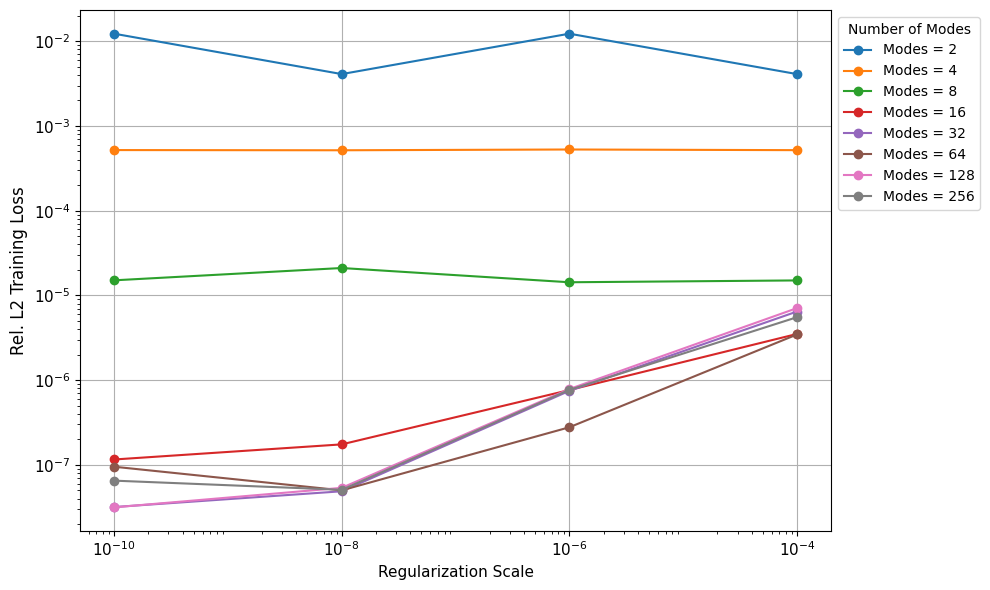

In [18]:
import json
import matplotlib.pyplot as plt
import numpy as np

# File names
file_names = [
    "burgers_results_n_[2]_avg.json",
    "burgers_results_n_[4]_avg.json",
    "burgers_results_n_[8]_avg.json",
    "burgers_results_n_[16]_avg.json",
    "burgers_results_n_[32]_avg.json",
    "burgers_results_n_[64]_avg.json",
    "burgers_results_n_[128]_avg.json",
    "burgers_results_n_[256]_avg.json"
]

# Function to extract number of modes from file name
def extract_modes(file_name):
    start = file_name.find('[') + 1
    end = file_name.find(']')
    return int(file_name[start:end])

# Setting up the plot
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figsize as needed

# Predefined ticks for the x-axis
x_ticks = [10**-10, 10**-8, 10**-6, 10**-4]

# Iterate over each file, plotting data on the same axes
for file_name in file_names:
    with open(file_name, 'r') as file:
        data = json.load(file)
        reg_loss_dict = {}

        for exp_key, exp in data.items():
            reg_scale = exp['trunk_config']['linear_layer']['regularization_scale']
            iteration_losses = [value for key, value in exp['training_info'].items() if 'loss' in key]
            best_loss = min(iteration_losses)
            
            if reg_scale in x_ticks:
                if reg_scale not in reg_loss_dict:
                    reg_loss_dict[reg_scale] = best_loss
                else:
                    reg_loss_dict[reg_scale] = min(reg_loss_dict[reg_scale], best_loss)

        sorted_keys = sorted(reg_loss_dict.keys())
        sorted_values = [reg_loss_dict[key] for key in sorted_keys]
        
        ax.plot(sorted_keys, sorted_values, marker='o', label=f'Modes = {extract_modes(file_name)}')

# Configure plot settings
ax.set_xscale('log')
ax.set_xticks(x_ticks)  # Set the specific ticks for the x-axis
ax.set_xlabel('Regularization Scale', fontsize=11)
ax.set_ylabel('Rel. L2 Training Loss', fontsize=12)
ax.grid(True)
ax.set_yscale('log')
ax.tick_params(axis='both', labelsize=11)

# Moving legend outside the plot
ax.legend(title="Number of Modes", loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

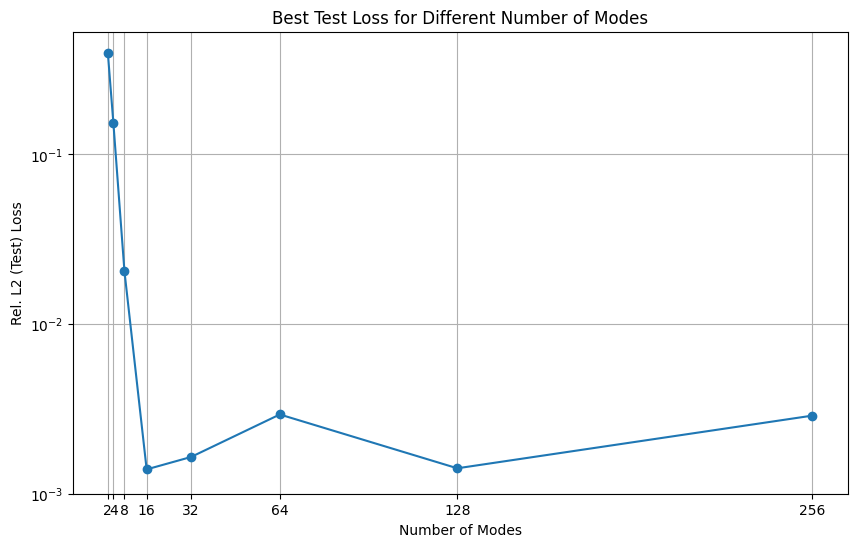

In [20]:
import json
import matplotlib.pyplot as plt

# File names
file_names = [
    "burgers_results_n_[2]_avg.json",
    "burgers_results_n_[4]_avg.json",
    "burgers_results_n_[8]_avg.json",
    "burgers_results_n_[16]_avg.json",
    "burgers_results_n_[32]_avg.json",
    "burgers_results_n_[64]_avg.json",
    "burgers_results_n_[128]_avg.json",
    "burgers_results_n_[256]_avg.json"
]

# Function to extract number of modes from file name
def extract_modes(file_name):
    start = file_name.find('[') + 1
    end = file_name.find(']')
    return int(file_name[start:end])

# Initialize lists
modes = []
best_test_losses_with_exp_num = []
layer_info = []  # To store layer width and activation information

# Process each file
for file_name in file_names:
    with open(file_name, 'r') as file:
        data = json.load(file)
        mode = extract_modes(file_name)
        modes.append(mode)

        best_loss_exp_number = None
        min_loss = float('inf')
        best_layer_width = None
        best_activation = None

        for exp_number, exp in data.items():
            if all(exp['training_info']['is_converged_values']):
                if exp['test_info']['test_loss_after_training'] < min_loss:
                    min_loss = exp['test_info']['test_loss_after_training']
                    best_loss_exp_number = exp_number
                    # Extract layer width and activation
                    best_layer_width = exp['branch_config']['dense_layer']['layer_width']
                    best_activation = exp['branch_config']['dense_layer']['activation']

        best_test_losses_with_exp_num.append((min_loss, best_loss_exp_number))
        layer_info.append((best_layer_width, best_activation))

# Extract just the loss values for plotting
best_test_losses = [loss for loss, exp_num in best_test_losses_with_exp_num]


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(modes, best_test_losses, marker='o')

plt.xlabel('Number of Modes')
plt.ylabel('Rel. L2 (Test) Loss')
plt.title('Best Test Loss for Different Number of Modes')
plt.xticks(modes)
plt.yscale('log')
plt.yticks([10**-1, 10**-2, 10**-3])
plt.gca().yaxis.set_minor_locator(plt.NullLocator())
plt.grid(True)
plt.show()


In [21]:
best_test_losses_with_exp_num

[(0.39663500678028635, 'experiment_28'),
 (0.15302674764592936, 'experiment_28'),
 (0.020415811088601188, 'experiment_28'),
 (0.0013910695619993023, 'experiment_28'),
 (0.001645799292163078, 'experiment_27'),
 (0.0029296667955753773, 'experiment_19'),
 (0.001411901141000084, 'experiment_28'),
 (0.0028840616201377595, 'experiment_20')]

Best experiment for burgers_results_n_[2]_avg.json is experiment_28
training_losses: [0.40312682249583287, 0.40312682249725856, 0.40312682249870313, 0.403126822500103]
Best experiment for burgers_results_n_[4]_avg.json is experiment_28
training_losses: [0.7408839434973776, 0.1512700276512421, 0.15127002765241118, 0.15127002765287847, 0.1512700276532409]
Best experiment for burgers_results_n_[8]_avg.json is experiment_28
training_losses: [0.7954086697819319, 0.020540715589232116, 0.0205407155545869, 0.02054071552510116, 0.020540715496791723]
Best experiment for burgers_results_n_[16]_avg.json is experiment_28
training_losses: [0.7951635384780749, 0.0010250945792737768, 0.0010250612798186143, 0.0010250378541453217, 0.0010250180472251955]
Best experiment for burgers_results_n_[32]_avg.json is experiment_27
training_losses: [0.7951630378923213, 0.0012086234021486289, 0.0012081391501902663, 0.0012080899582783118, 0.0012077425088542501, 0.0008026700516503901, 0.00039741350294346774]
Best exp

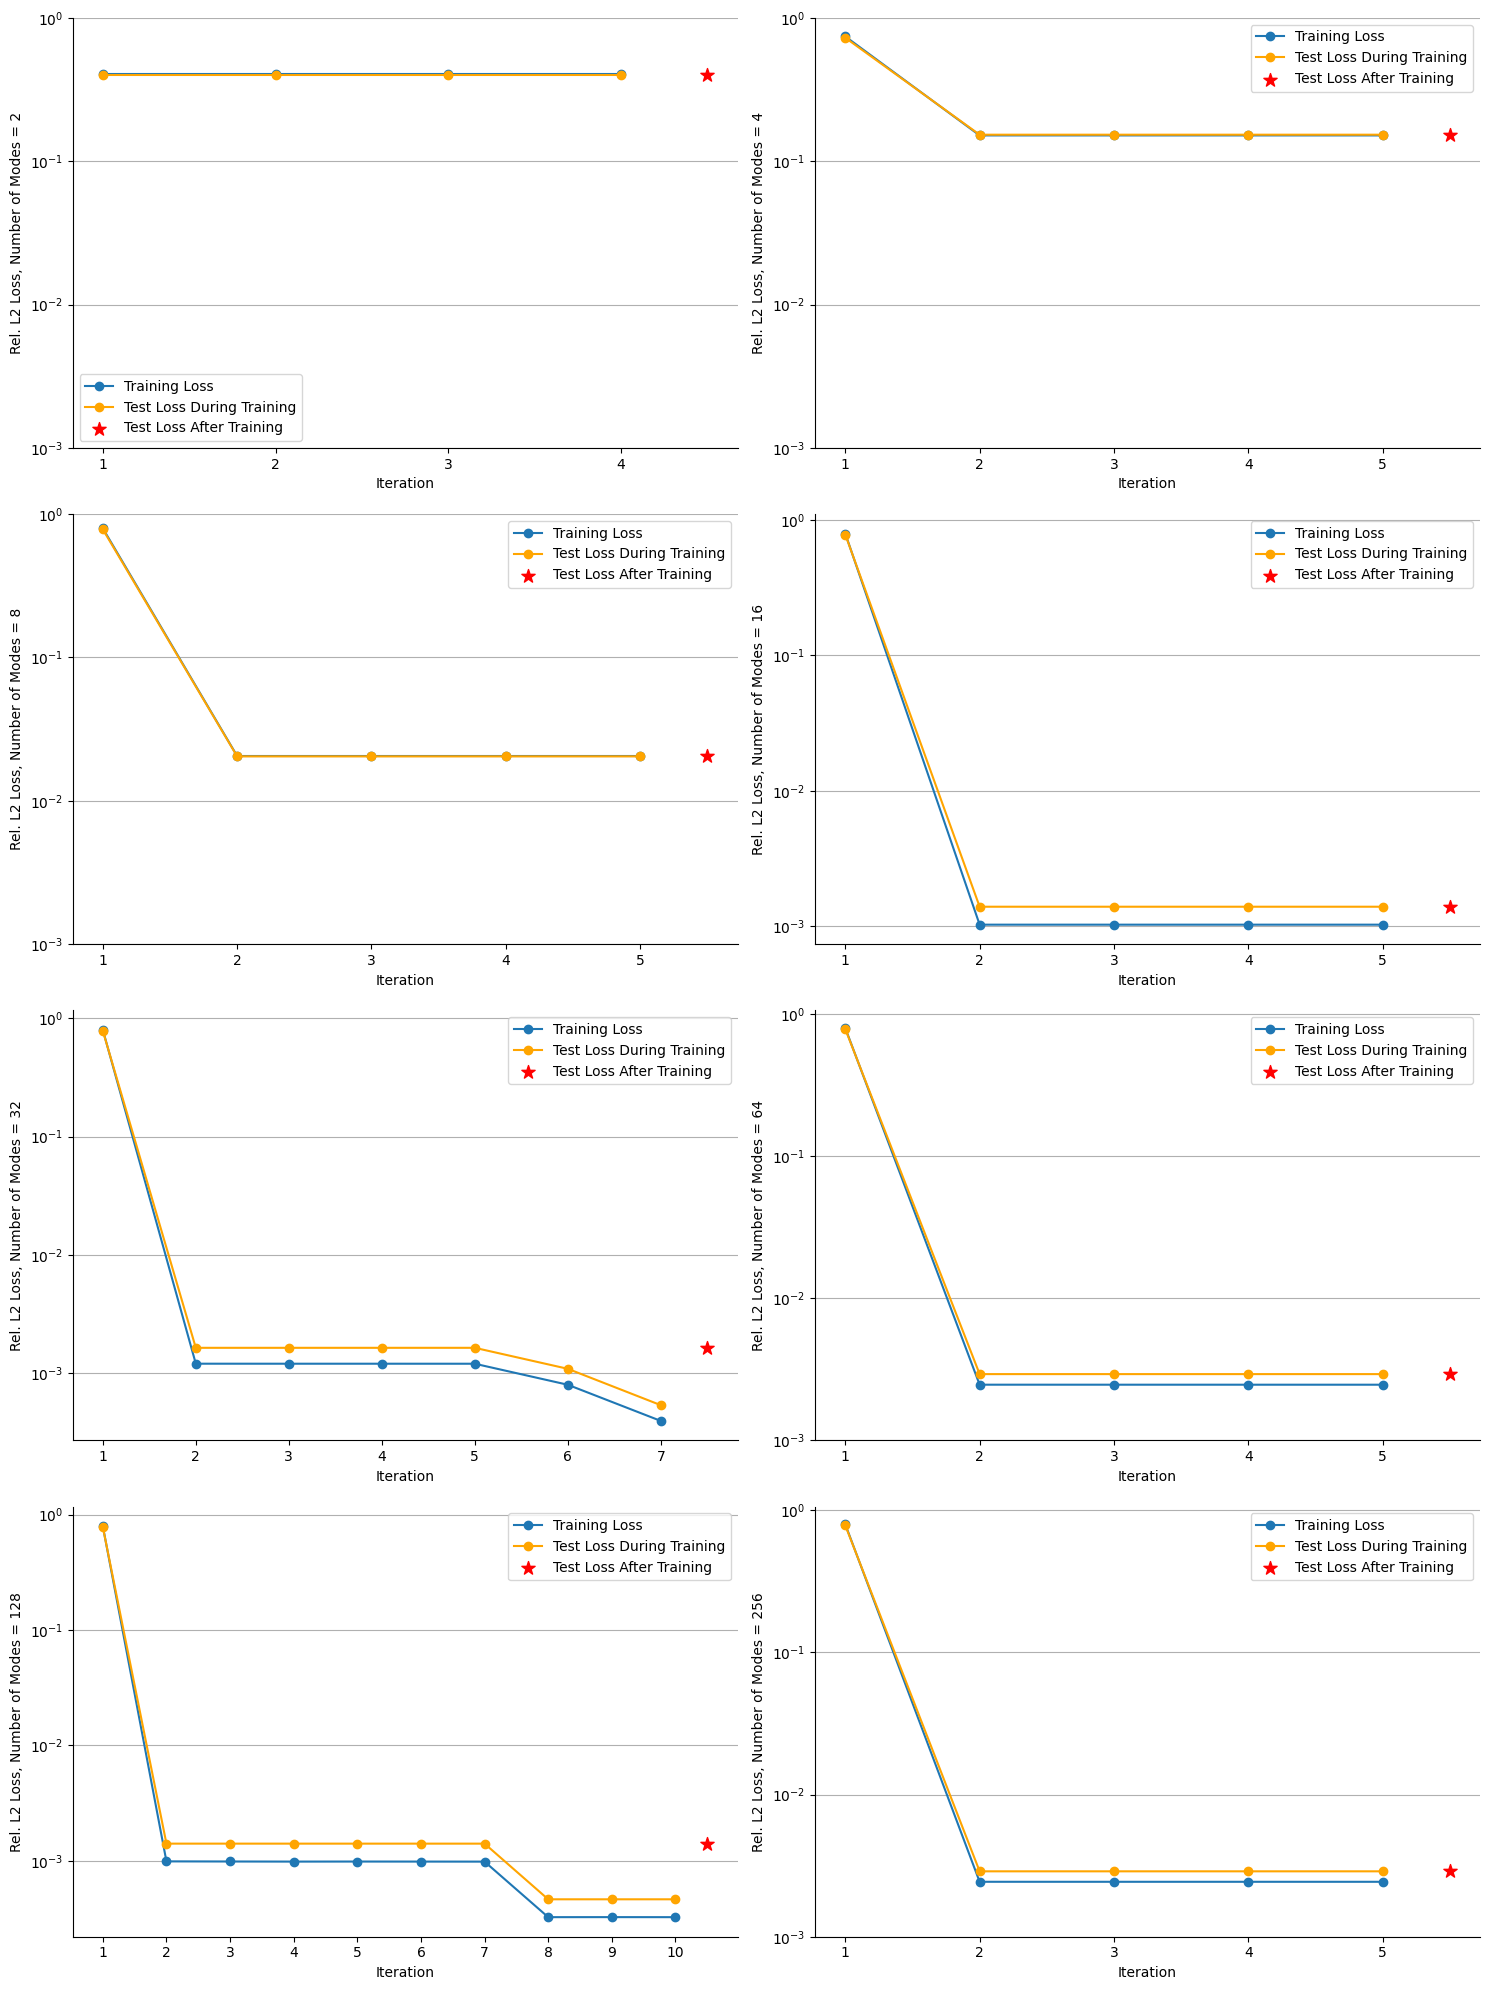

Best experiments for each file:
{}


In [22]:
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# Define the file names
file_names = [
    "burgers_results_n_[2]_avg.json",
    "burgers_results_n_[4]_avg.json",
    "burgers_results_n_[8]_avg.json",
    "burgers_results_n_[16]_avg.json",
    "burgers_results_n_[32]_avg.json",
    "burgers_results_n_[64]_avg.json",
    "burgers_results_n_[128]_avg.json",
    "burgers_results_n_[256]_avg.json"
]

def extract_modes(file_name):
    start = file_name.find('[') + 1
    end = file_name.find(']')
    return int(file_name[start:end])

# Initialize the figure for subplots (4 rows, 2 columns)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))
axes = axes.flatten()  # Flatten the 2D array of axes for easy indexing

# Dictionary to save the best experiment numbers
best_experiments = {}

# Determine global min and max loss for standardizing y-axis ticks
global_min_loss = float('inf')
global_max_loss = float('-inf')

# Process each file to find global min and max
for file_name in file_names:
    with open(file_name, 'r') as file:
        data = json.load(file)
        for experiment, details in data.items():
            test_loss = details['test_info']['test_loss_after_training']
            if test_loss < global_min_loss:
                global_min_loss = test_loss
            if test_loss > global_max_loss:
                global_max_loss = test_loss

# Determine the log scale ticks based on the overall min and max losses
log_min = np.floor(np.log10(global_min_loss))
log_max = np.ceil(np.log10(global_max_loss))
uniform_ticks = np.logspace(log_min, log_max, num=4)

# Plotting for each file
for i, file_name in enumerate(file_names):
    with open(file_name, 'r') as file:
        data = json.load(file)

    # Find the experiment with the lowest test loss
    best_test_loss = float('inf')
    best_experiment_number = None
    for experiment, details in data.items():
        if all(details['training_info']['is_converged_values']):
            test_loss = details['test_info']['test_loss_after_training']
            if test_loss < best_test_loss:
                best_test_loss = test_loss
                best_experiment_number = experiment
    print(f"Best experiment for {file_name} is {best_experiment_number}")
    # Extract training losses for the best experiment
    best_experiment_data = data[best_experiment_number]['training_info']
    training_losses = [best_experiment_data[f'iteration_{j}_loss'] for j in range(1, 11) if f'iteration_{j}_loss' in best_experiment_data]
    print(f"training_losses: {training_losses}")

    # Plot the training losses in blue
    ax = axes[i]
    ax.plot(range(1, len(training_losses) + 1), training_losses, marker='o', label='Training Loss')

    # Extract and plot the test losses during training in orange
    test_losses = [data[best_experiment_number]['test_info'][f'iteration_{j}_test_loss'] for j in range(1, 11) if f'iteration_{j}_test_loss' in data[best_experiment_number]['test_info']]
    ax.plot(range(1, len(test_losses) + 1), test_losses, marker='o', color='orange', label='Test Loss During Training')

    
    # Plot the 'test_loss_after_training' value with a different marker
    ax.scatter(len(training_losses) + 0.5, best_test_loss, marker='*', color='red', s=100, label='Test Loss After Training')
    #ax.annotate('Test Loss After\nTraining', (len(training_losses) + 0.5, best_test_loss), textcoords="offset points", xytext=(10,-10), ha='center')

    ax.set_xlabel('Iteration')
    ax.set_ylabel(f'Rel. L2 Loss, Number of Modes = {extract_modes(file_name)}')
    ax.set_yscale('log')
    ax.set_yticks([1, 10**-1, 10**-2, 10**-3])
    ax.get_yaxis().set_major_formatter(ticker.LogFormatterMathtext())
    ax.xaxis.set_major_locator(ticker.FixedLocator(range(1, 11))) 

    # Clean up axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.grid(True)  # Only horizontal grid lines
    ax.xaxis.grid(False)
    ax.yaxis.set_minor_locator(ticker.NullLocator())
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Output the dictionary of best experiments
print("Best experiments for each file:")
print(best_experiments)
